# Model Selection via Regularization

In this exercise, we will introduce regularization terms in our regression models to prevent overfitting. Let the covariates be $x \in \mathbb{R}^{n \times p}$ and the outcomes be $Y \in \mathbb{R}^n$. $x_j^{\left(i\right)}$ denotes the $j$th feature in the $i$th sample, while $Y^{\left(i\right)}$ denotes the outcome for the $i$th sample. The linear regression model is 

\begin{equation*}
    Y^{\left(i\right)} = \beta_0 + \sum_{j = 1}^p \beta_j x_j^{\left(i\right)} + Z^{\left(i\right)}
\end{equation*}

Let $\lambda$ be the regularization constant. Ridge regression (L2 regularization) penalizes the squared magnitude of the coefficients:

\begin{equation*}
    \hat{\beta}^{L2} = {\rm arg\,min}_{\beta} \left(\sum_{i=1}^n \left(Y^{\left(i\right)} - \sum_{j = 1}^p \beta_j x_j^{\left(i\right)} - \beta_0\right)^2 + \lambda \sum_{j=1}^p \beta_j^2\right)
\end{equation*}

LASSO regression (L1 regularization) penalizes the absolute value of the magnitude of the coefficients:

\begin{equation*}
    \hat{\beta}^{L1} = {\rm arg\,min}_{\beta} \left(\sum_{i=1}^n \left(Y^{\left(i\right)} - \sum_{j = 1}^p \beta_j x_j^{\left(i\right)} - \beta_0\right)^2 + \lambda \sum_{j=1}^p \lvert \beta_j \rvert\right)
\end{equation*}

Note that neither Ridge nor LASSO penalizes the intercept. If the intercept is regularized, many properties of linear regression will no longer hold.

We will compare the effects of L2 (Ridge) and L1 (LASSO) regularization on the coefficients. To understand how each value of the regularization constant constrains the model, we will compute the effective degrees of freedom. We will also use LOOCV (Leave-One-Out-Cross-Validation) to choose the right regularization parameter and hence the best model.

For this exercise, we will use the cars dataset. It is provided as <b>cars.csv</b> in the data directory. For information on what the features are, refer to https://www.rdocumentation.org/packages/datasets/versions/3.6.2/topics/mtcars Note that this is a different automobile dataset from the OLS part. In this part, we will also build regression models to predict miles per gallon, this time from 10 features.

In [354]:
#Import the necessary libraries
%matplotlib inline

from matplotlib import pyplot as plt
from patsy import dmatrices
import utils
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
import warnings

# some settings
warnings.filterwarnings('ignore')
plt.rc('font', size = 14)

Read the data as a pandas dataframe. For reference: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [355]:
# Read the data
filename = 'data/cars.csv'
df = pd.read_csv(filename)

# (0). Visualize the data

**(0a).** [1 pt] Print the number of observations in the dataset. 

In [356]:
print(len(df))

32


**(0b).** [1 pt] Print all the columns in the dataset

In [357]:
print(df)

                   name   mpg  cyl   disp   hp  drat     wt   qsec  vs  am  \
0             Mazda RX4  21.0    6  160.0  110  3.90  2.620  16.46   0   1   
1         Mazda RX4 Wag  21.0    6  160.0  110  3.90  2.875  17.02   0   1   
2            Datsun 710  22.8    4  108.0   93  3.85  2.320  18.61   1   1   
3        Hornet 4 Drive  21.4    6  258.0  110  3.08  3.215  19.44   1   0   
4     Hornet Sportabout  18.7    8  360.0  175  3.15  3.440  17.02   0   0   
5               Valiant  18.1    6  225.0  105  2.76  3.460  20.22   1   0   
6            Duster 360  14.3    8  360.0  245  3.21  3.570  15.84   0   0   
7             Merc 240D  24.4    4  146.7   62  3.69  3.190  20.00   1   0   
8              Merc 230  22.8    4  140.8   95  3.92  3.150  22.90   1   0   
9              Merc 280  19.2    6  167.6  123  3.92  3.440  18.30   1   0   
10            Merc 280C  17.8    6  167.6  123  3.92  3.440  18.90   1   0   
11           Merc 450SE  16.4    8  275.8  180  3.07  4.070  17.

**(0c).** [1 pt] Produce a Scatter plot of all variables against each other.

Feel free to use the <b>scatter_plot_dataframe()</b> function in utils.py. Note: this function call may take a while.

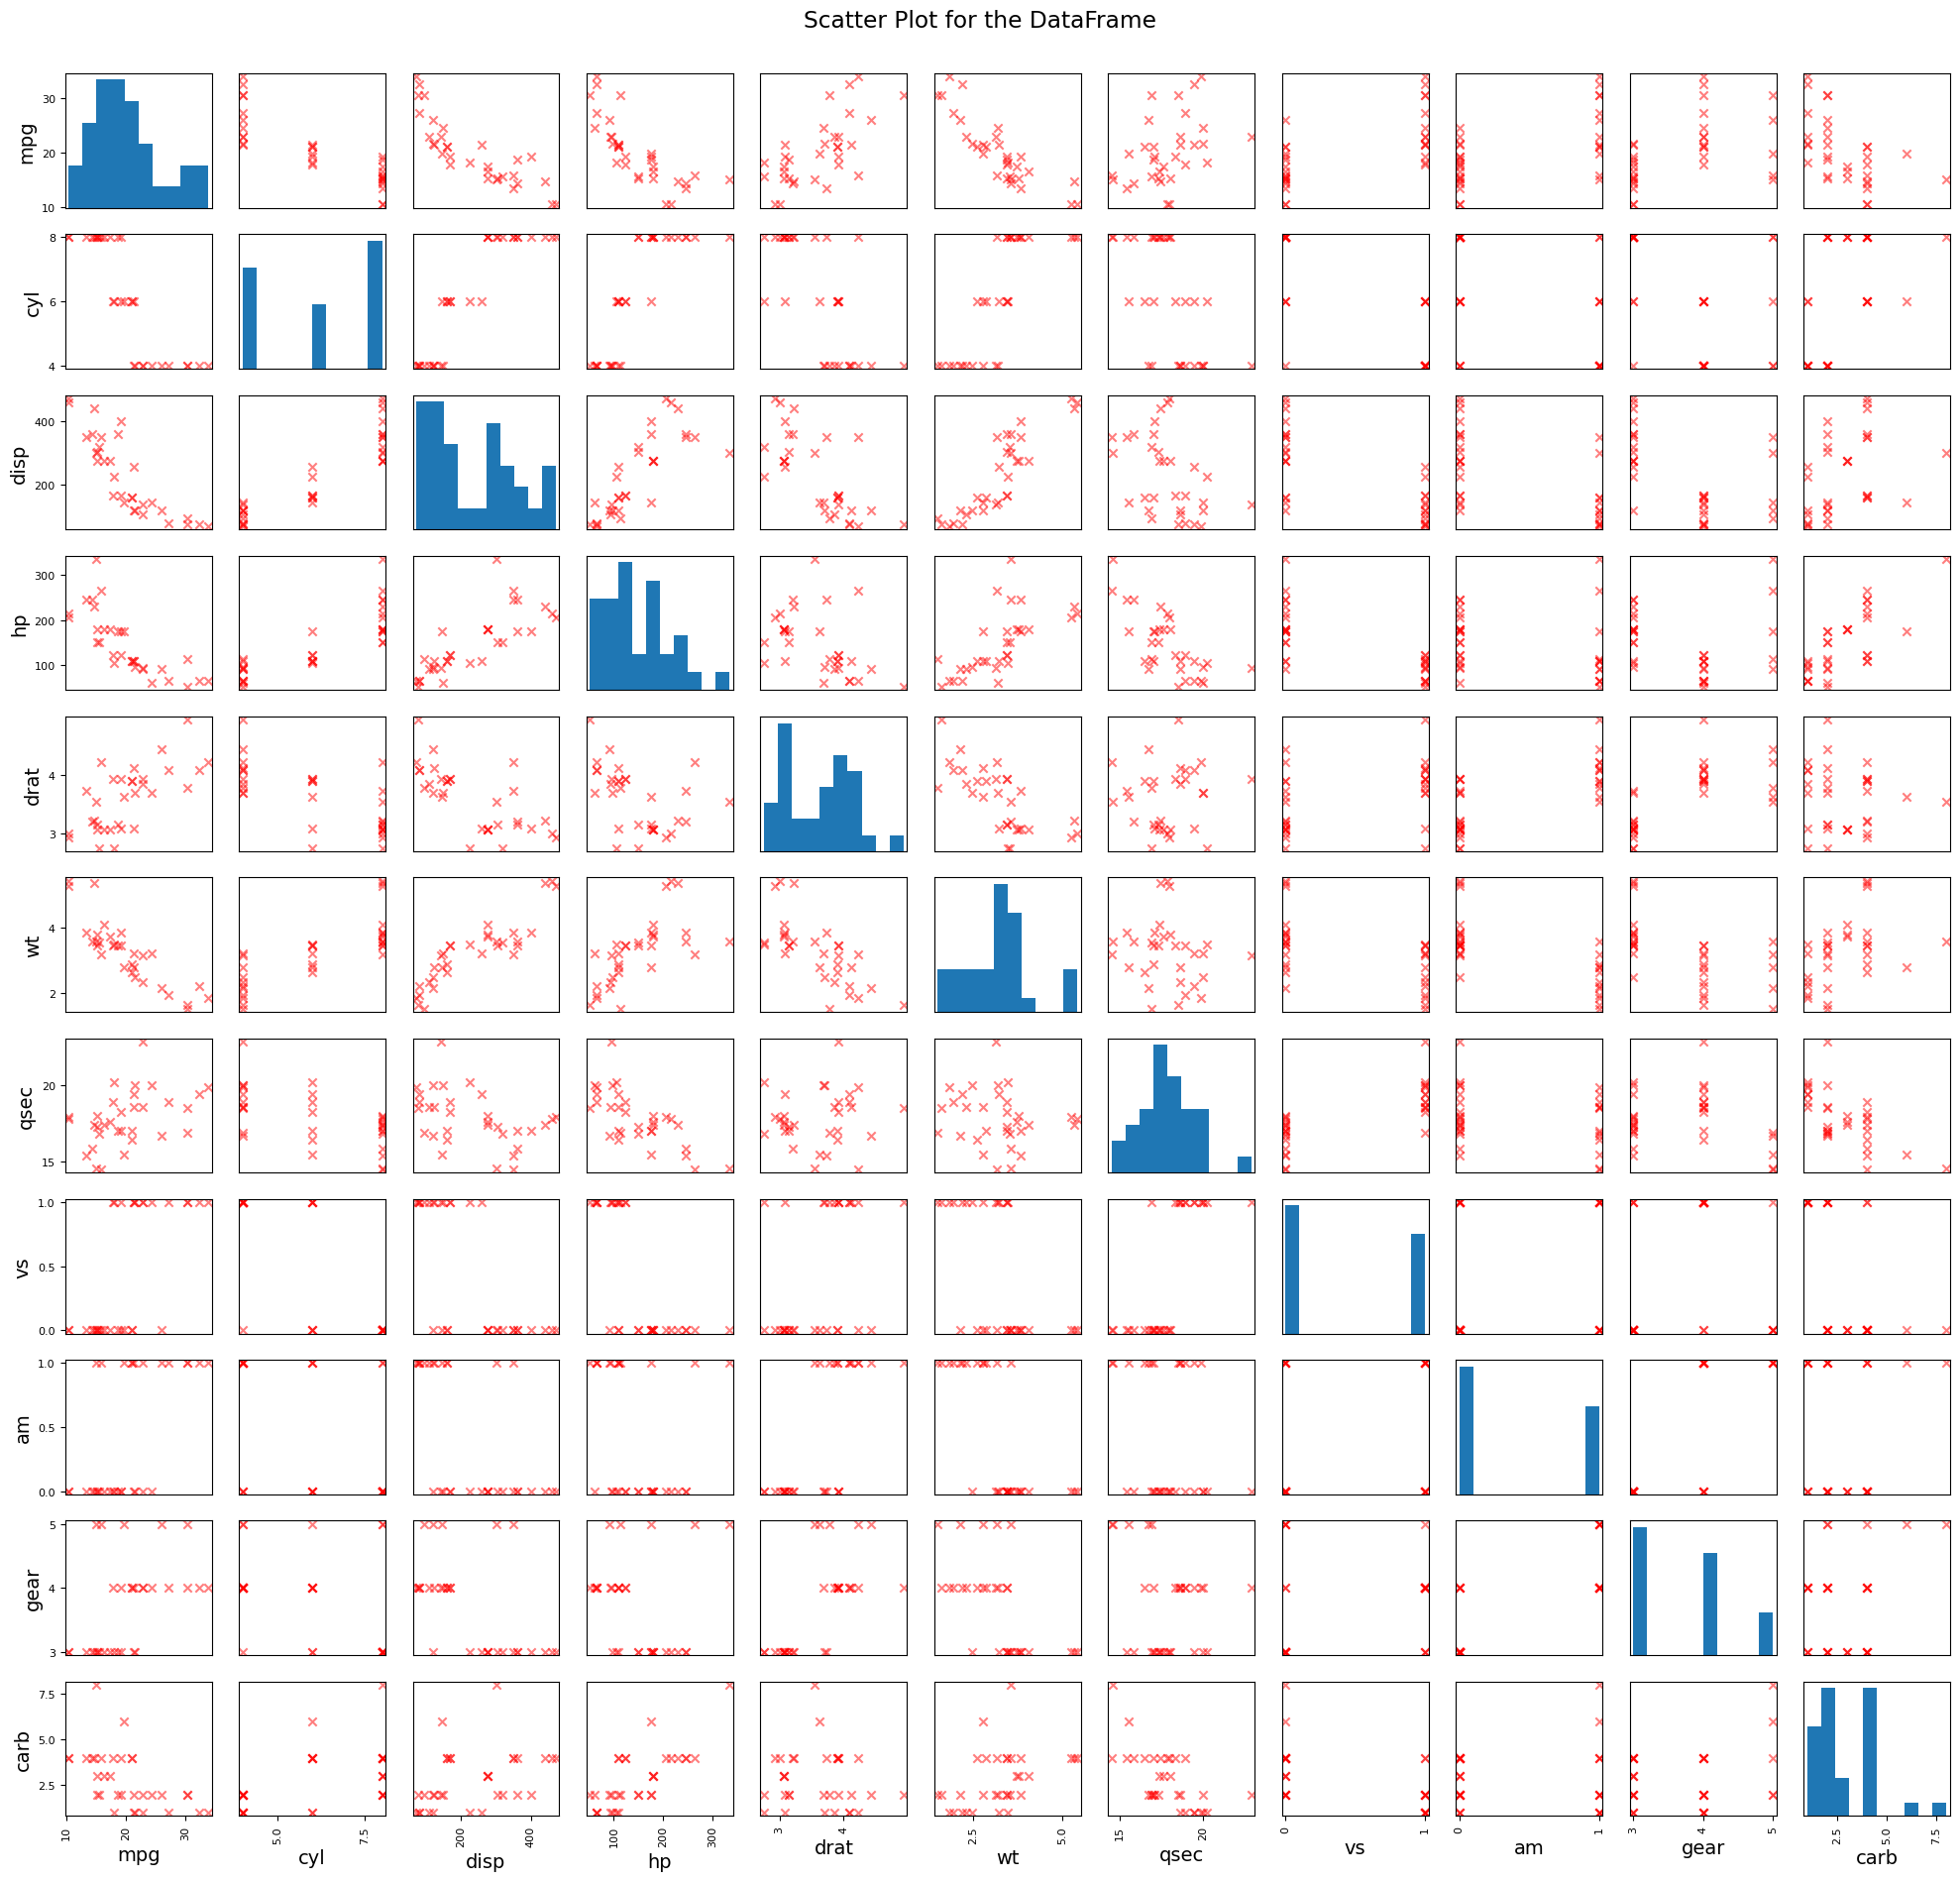

In [358]:
utils.scatter_plot_dataframe(df)

**(0d).** [1 pt] Produce a plot of correlations between all variables.

Feel free to use the <b>correlation_plot()</b> function in utils.py

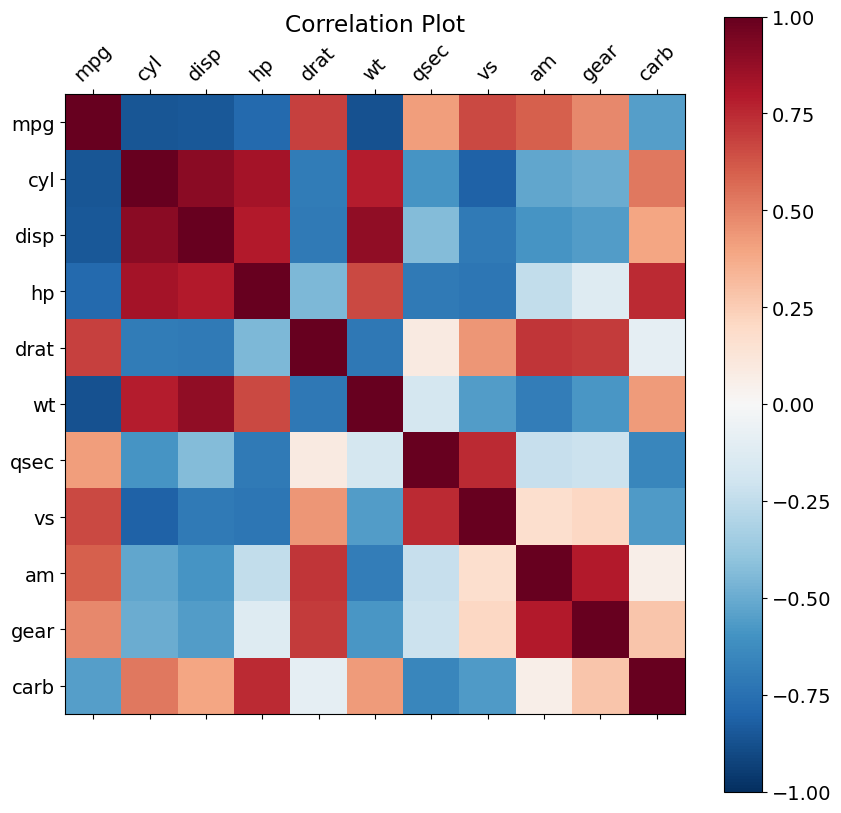

In [359]:
utils.correlation_plot(df)

**(0e).** [1 pt] Using the plots above, which variables have a (roughly) linear relationship with 'mpg'? 

**A:** drat, vs

# (1). Ridge Regression
We will run Ridge regression by introducing an L2 penalty on the regression coefficients.

In [360]:
feat_names = ['cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb']

**(1a).** [3 pts] Create an OLS model using <b>statsmodels.OLS</b> You do not have to fit the model in this step.

The dependent variable is 'mpg', and the independent variables are 'cyl', 'disp', 'hp', 'drat', 'wt', 'qsec', 'vs', 'am', 'gear', 'carb'.

Center and normalize each independent variable. Regularization penalizes coefficients based on their magnitude. Because features on different scales have coefficients of different magnitudes, standardizing features is important to ensure regularization is applied evenly.

Include the intercept using the add_constant() function in statsmodels. Store your multi-variate model in a variable called <b>mv_model</b>.

Hint: http://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html

In [361]:
def normalize(arr):
    mean = np.mean(arr)
    std = np.std(arr)
    arr -= mean
    arr /= std
    return arr
expr = 'mpg ~ cyl + disp + hp + drat + wt + qsec + vs + am + gear + carb'

y_train, X_train = dmatrices(expr, df, return_type='dataframe')
for feat in feat_names:
    X_train[feat] = normalize(X_train[feat])

mv_model = sm.regression.linear_model.OLS(y_train, X_train)
#print(mv_model.fit().summary())

**(1b).** [2 pts] Write a function <b>get_mv_ridge()</b> which fits a model with an L2 regularization constant $\lambda$. Your function should take as arguments the statsmodels OLS model and $\lambda$ and return the fit.

Use statsmodels' <b>fit_regularized()</b> function: https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html Note the objective function in their documentation uses a different regularization constant $\alpha$:

\begin{equation*}
    \hat{\beta}^{L2} = {\rm arg\,min}_{\beta} \left(\frac{1}{2n} \sum_{i=1}^n \left(Y^{\left(i\right)} - \sum_{j = 1}^p \beta_j x_j^{\left(i\right)} - \beta_0\right)^2 + \frac{\alpha}{2} \sum_{j=1}^p \beta_j^2\right)
\end{equation*}

Be sure to account for this change from $\lambda$ to $\alpha$ and for no regularization on the intercept in your function.

In [362]:
def get_mv_ridge(model,
                 ridge_lambda):
    '''
    Compute a Ridge regression
    @param model: statsmodels OLS
    @param ridge_lambda: float, L2 regularization constant
    @return: fitted OLS model (RegularizedResults)
    '''
    return model.fit_regularized(alpha=[0]+[2*ridge_lambda]*10, L1_wt=0)

**(1c).** [3 pts] The number of degrees of freedom is the number of values that are free to vary. When regularization is applied, the number of effective degrees of freedom is reduced. The formula for Ridge effective degrees of freedom is:

$$
\mathrm{df}(\lambda) = \mathrm{tr}(X^T(X^TX + \lambda I)^{-1}X^T) + 1 = \sum_{j=1}^p \frac{d_j^2}{d_j^2 + \lambda} + 1,
$$
where $X$ is the $n\times p$ column-centered matrix (without constant) holding the independent variables, and $d_j$ are the diagonal entries of $D$ in the SVD decomposition of $X$:
$$
X = UDV^T
$$

Since the intercept contributes 1 degree of freedom, a 1 is added.

Define a function <b>degrees_of_freedom_ridge</b> that takes $X$ and the L2 regularization constant $\lambda$ as input and computes the effective degrees of freedoms. 

In [363]:
def degrees_of_freedom_ridge(X,
                             ridge_lambda):
    '''
    Compute the number of effective degrees of freedom for a ridge regression
    @param X: pandas DataFrame, column-centered data, may contain 'const' column
    @param ridge_lambda: float, L2 regularization constant
    @return: float, effective degrees of freedom
    '''
    svd = np.linalg.svd(X)[1]
    df = 0
    for d in svd:
        df += d**2 / (d**2+ridge_lambda)
    return df+1



**(1d).** [3 pts] Use <b>get_mv_ridge()</b> to plot the Ridge regression coefficients vs. effective degrees of freedom $\mathrm{df}(\lambda)$ for each independent variable for $\lambda$ in the range [0,3200] in increments of 3.2. Use smaller increments of 0.32 from 0 to 3.2 since small values of $\lambda$ are more sensitive and hence require greater accuracy.<br>

Ensure that your legend clearly labels all lines (one per variable) and the axes are appropriately labeled (x-axis should have $\mathrm{df}(\lambda)$ and the y-axis should have the parameter values).

Text(0.5, 1.0, 'regression coefficients vs. effective df')

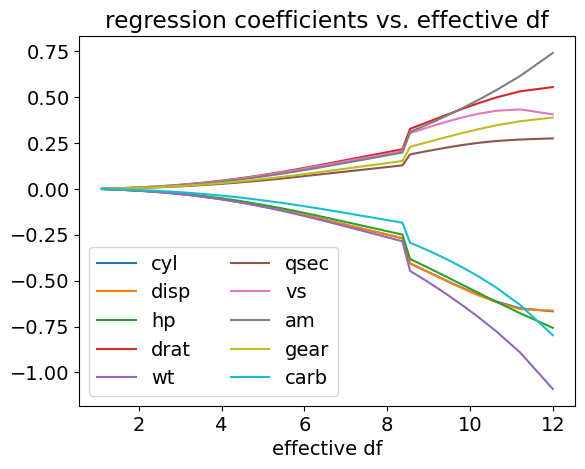

In [364]:
lam = 0
dfs = []
lams = []
params = []
while lam < 3200: 
    #store lambdas and corresponding df
    dfs.append(degrees_of_freedom_ridge(X_train, lam))
    lams.append(lam)
    #step size depending on lambda
    if lam < 2.89:
        lam += .32
    else:
        lam += 3.2
    
    #fit ridge model iwth given lambda and get parameters
    p = get_mv_ridge(mv_model, lam).params
    params.append(p[1:])

params = np.array(params).T
for i in range(len(params)):
    plt.plot(dfs, params[i])
 
    
plt.legend(feat_names, ncol=2)
plt.xlabel('effective df')
plt.title('regression coefficients vs. effective df')


**(1e).** [1 pt] What do you notice about the coefficients as the degrees of freedom decrease? 

**A:** Their magnitude decreases

**(1f).** [3 pts] Define a function <b>LOOCV_ridge(lambda)</b> which implements Leave-One-Out-Cross-Validation on the Ridge regression model as a function of the penalty parameter $\lambda$. In particular, for every $1 \leq i \leq n$ where $n$ is the sample size, train a ridge regression model on the sub-sample where the $i^{th}$ sample is removed. Evaluate this model on the remaining $i^{th}$ sample using squared error loss. Then return the average/standard deviation of this loss over all $n$ iterations.

Note: There is also an efficient way to implement this function without training a new ridge regression model for each LOOCV iteration. While this solution is not required, thinking about it is a nice exercise!

In [365]:
def LOOCV_ridge(X,
                Y,
                ridge_lambda):
    '''
    Perform leave one out cross validation on a ridge regression model
    Compute the average and standard deviation of the loss on the held-out sample across all iterations
    @param X: pandas DataFrame, column-centered data, contains 'const' column
    @param Y: np array, sample labels
    @param ridge_lambda: float, L2 regularization constant
    @return: 1. float, mean of LOOCV scores
             2. float, standard deviation of LOOCV scores
    '''
    loocv_scores = []
    for i in range(len(X)):
        mask = np.ones(len(X))
        #leave out one data point
        mask[i] = 0
        mask = np.array(mask, dtype='bool')
        
        #train on all but 1
        X_train, y_train = X[mask], Y[mask]
        X_test, y_test = X[~mask], Y[~mask]
    
        #fit and compute error
        mv_model = sm.regression.linear_model.OLS(y_train, X_train)
        model = get_mv_ridge(mv_model, ridge_lambda)
        loocv_scores.append((model.predict(X_test)-y_test['mpg'][i])**2)
        
    return np.mean(loocv_scores), np.std(loocv_scores)
                                      



**(1g).** [2 pts] Use <b>LOOCV_ridge(lambda)</b> and <b>degrees_of_freedom_ridge(lambda)</b> to generate three arrays: <b>ridge_x_vals</b>, <b>ridge_y_vals</b>, <b>ridge_error_bars</b> holding the degrees of freedom, LOOCV score, and standard errors, correspondingly. <br>The computation is expensive and may take a couple of minutes.

In [366]:
expr = 'mpg ~ cyl + disp + hp + drat + wt + qsec + vs + am + gear + carb'
Y, X = dmatrices(expr, df, return_type='dataframe')
ridge_x_vals = []
ridge_y_vals = []
ridge_error_bars = []
for lam, df in zip(lams, dfs):
    ridge_x_vals.append(df)
    mean, std = LOOCV_ridge(X, Y, lam)
    ridge_y_vals.append(mean)
    ridge_error_bars.append(std/np.sqrt(32))
    

    
    

**(1h).** [2 pts] Use the arrays you generated in part (1g) to plot the Leave-One-Out-Cross-Validation score (with error bars) vs. effective degrees of freedom $\mathrm{df}(\lambda)$. Ensure that the axes are appropriately labeled (x-axis should have df(lambda) and the y-axis should have the LOOCV score).

<b>Hint:</b> You might want to plot the y-axis on a log scale for better readibility.

<ErrorbarContainer object of 3 artists>

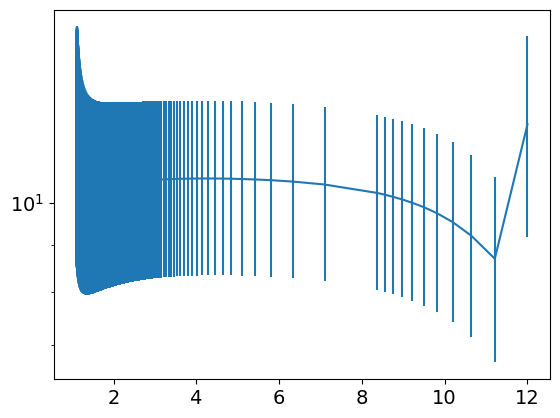

In [367]:
plt.yscale('log')
plt.errorbar(ridge_x_vals, ridge_y_vals, yerr=ridge_error_bars)



**(1i).** [1 pt] We can pick the best lambda based on which value minimizes the mean LOOCV score. What is the best lambda? What are the corresponding degrees of freedom and mean LOOCV score?

In [368]:
print(f'Lambda= {lams[ridge_y_vals.index(min(ridge_y_vals))]}')
print(f'Df= {dfs[ridge_y_vals.index(min(ridge_y_vals))]}')
print(f'LOOCV score= {min(ridge_y_vals)}')

Lambda= 0.32
Df= 11.210634119340657
LOOCV score= 8.687726816573406


**(1j).** [1 pt] Build and fit a ridge regression model with this $\lambda$ and no held-out data.

In [369]:
model = get_mv_ridge(mv_model, .32)

**(1k).** [1 pt] Display the coefficients in a pandas DataFrame.

Hint: A RegularizedResults object does not have **summary()** implemented, so use the **params** property instead

In [370]:

results = pd.DataFrame(model.params)
row_labels = {0: 'Intercept'}
for i in range(1, 11):
    row_labels[i] = feat_names[i-1]
results.rename(index= row_labels, inplace=True)
print(results)

                   0
Intercept  20.090625
cyl        -0.667027
disp       -0.663675
hp         -0.756977
drat        0.554786
wt         -1.089905
qsec        0.275352
vs          0.406328
am          0.740818
gear        0.388902
carb       -0.797260


**(1l).**  [1 pt] How would you interpret the coefficient on cylinders?

Hint: You will need to apply the normalization (but not the centering) introduced in 1a to the coefficient before interpreting it.

**A:** The coefficient is still the predicted change in the target per unit change in the input, but now, it is per normalized unit (standard deviation)

# (2). LASSO (Least Absolute Shrinkage and Selection Operator)

We will now run LASSO by introducing an L1 penalty on the regression coefficients. Normalizing features is also important for applying L1 regularization evenly. We will use the normalized features created in (1a).

**(2a).** [2 pts] A LASSO coefficient path shows how the coefficients change as the L1 penalty is varied. Write a function **compute_lasso_path(X, Y, alphas)** that takes in the scaled features X (without intercept) and the outcomes Y. Your function should output a numpy array where each column contains the intercept (at index 0) and the coefficients for that value of alpha.

We recommend you take one of these approaches:

1. Use **sklearn.linear_model.Lasso** to fit a model for each $\alpha$: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
2. Use **sklearn.linear_model.lasso_path**: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html To avoid regularizing the intercept, center Y before calling this function since the intercept will be 0 on the centered Y. You can manually add the intercept after. Also, note that the order of the alphas will be reversed by this function, so you will have to handle the outputted lasso paths accordingly.

Note that $\alpha$ is also different from $\lambda$ in this objective:
\begin{equation*}
    \hat{\beta}^{L1} = {\rm arg\,min}_{\beta} \left(\frac{1}{2n}\sum_{i=1}^n \left(Y^{\left(i\right)} - \sum_{j = 1}^p \beta_j x_j^{\left(i\right)} - \beta_0\right)^2 + \alpha \sum_{j=1}^p \lvert \beta_j \rvert\right)
\end{equation*}

We will use $\alpha$ as defined in the sklearn documentation for this problem, so you do not need to convert from $\lambda$.

In [371]:
def compute_lasso_path(X,
                       Y,
                       alphas):
    '''
    Compute the LASSO coefficient path as alpha is varied
    @param X: np array, # samples x # features, does not contain a constant column
    @param Y: np array, # samples, contains outcomes
    @param alphas: list of floats, alpha values on LASSO path
    @return: np array, (1 + # features) * # alphas, first row contains intercepts
    '''
 
    # Initialize the LASSO object
    lasso = linear_model.Lasso()
    
    # Compute the LASSO path for each alpha
    coefs = []
    for a in alphas:
        lasso.set_params(alpha=a)
        lasso.fit(X, Y)
        coefs.append(lasso.coef_)
    
    # Convert the list of coefficient arrays into a numpy array
    coefs = np.array(coefs).T
    #coefs[0] += np.mean(Y)
    
    return coefs








**(2b).** [1 pt] Compute the LASSO path for each value of $\alpha$ in the range [0.001,100] in 1000 small increments **equally spaced on the log scale**. Hold your results in **main_lasso_path**.

Then plot the LASSO coefficients vs $\log_{10}\left(\alpha\right)$. The intercept does not need to be plotted. Ensure that your legend clearly labels all lines (one per each variable) and the axes are appropriately labeled (x-axis should have log alpha and the y-axis should have the parameter values).

Text(0.5, 1.0, 'regression coefficients vs. alpha')

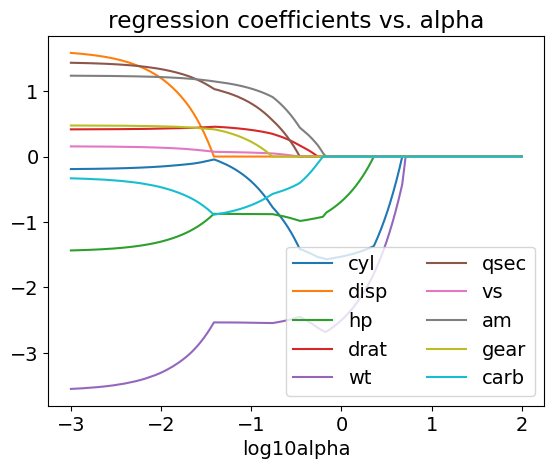

In [372]:
alphas = np.logspace(-3, 2, num=1000)
main_lasso_path = compute_lasso_path(np.array(X_train), np.array(y_train), alphas)
for i in range(1, 11):
    plt.plot(np.log10(alphas), main_lasso_path[i])

plt.legend(feat_names, ncol=2)
plt.xlabel('log10alpha')
plt.title('regression coefficients vs. alpha')


**(2c).** [1 pt] What do you notice about the coefficients as the regularization penalty is increased? Contrast the behavior with what you observed for Ridge Regression? Which might you prefer for choosing a sparse subset of features (columns) in a regression model?

**A:** The coefficients don't just converge to 0 like in ridge but are set to 0 exactly once a threshold is reached. This is preferable for a sparse subset of features.

**(2d).** [1 pt] To Implement LOOCV for Lasso regression, we need to fit the Lasso model on every sub-sample where the $i^{th}$ sample is removed for $1\leq i\leq n$. In this part, we'll do some pre-computation. Pre-compute $n$ lasso paths using **compute_lasso_path** for every sub-sample. Save your results in **sub_lasso_paths**, an numpy array of size $n \times p \times $ # alphas

In [373]:
sub_lasso_paths = []
for i in range(len(X_train)):
    #leave one out with mask
    mask = np.ones(len(X_train))
    mask[i] = 0
    mask = np.array(mask, dtype='bool')
    #train on rest
    X, Y = X_train[mask], y_train[mask]
    sub_lasso_paths.append(compute_lasso_path(X, Y, alphas))

**(2e).** [2 pts] Define a function <b>LOOCV_lasso</b> which implements Leave-One-Out-Cross-Validation on the Lasso regression model. Use the coefficients in pre-computed lasso paths instead of fitting an OLS model. The rest of the procedure is the same as the one for Ridge regression.  This function will take your pre-computed **sub_lasso_paths**, **alpha_index**, and the samples as input. It will return the mean and standard deviation of the LOOCV scores.

In [374]:
sub_lasso_paths = np.array(sub_lasso_paths)
def LOOCV_lasso(sub_lasso_paths,
                alpha_index,
                X,
                Y):
    '''
    Perform leave one out cross validation on a Lasso regression model
    This model is represented by the coefficients at alpha_index in sub_lasso_paths
    Compute the mean and standard deviation of loss on the held-out sample
    @param sub_lasso_paths: np array, # samples x # coefficients x # alphas
    @param alpha_index: int, alpha index
    @param X: pandas DataFrame, column-centered data, contains 'const' column
    @param Y: np array, sample labels
    @return: 1. float, mean of LOOCV scores
             2. float, standard deviation of LOOCV scores
    '''
    loocv_scores = []
    for i in range(len(X)):
        #leave one out with mask
        mask = np.ones(len(X))
        mask[i] = 0
        mask = np.array(mask, dtype='bool')
        #test on left out
        X_test, Y_test = X[~mask], Y[~mask] 
        #extract coefficients from lasso path
        lasso_path = sub_lasso_paths[i]
        coefs = [np.mean(Y)]
        for c in lasso_path[1:]:
            coefs.append(c[alpha_index])
        #compute error
        loocv_scores.append(((X_test@coefs).item()-Y_test)**2)
    return np.mean(loocv_scores), np.std(loocv_scores)
        


**(2f).** [2 pts] Use <b>LOOCV_lasso</b> to generate three arrays: <b>lasso_x_vals</b>, <b>lasso_y_vals</b>, <b>lasso_error_bars</b> for $\log_{10}\left(\alpha\right)$, LOOCV score, and standard errors, respectively

In [375]:
lasso_x_vals = []
lasso_y_vals = []
lasso_error_bars = []
for i in range(len(alphas)):
    alpha = alphas[i]
    mean, std = LOOCV_lasso(sub_lasso_paths, i, X_train, y_train)
    lasso_x_vals.append(np.log10(alpha))
    lasso_y_vals.append(mean)
    lasso_error_bars.append(std/np.sqrt(32))

**(2g).** [2 pts] Use the arrays you generated in part (2f) to plot the Leave-One-Out-Cross-Validation score (with error bars) vs. $\log_{10}\left(\alpha\right)$.

Ensure that your legend clearly labels all lines (one per each variable) and the axes are appropriately labeled (x-axis should have log alpha and the y-axis should have the LOOCV score).

Hint: You might want to plot the y-axis on a log scale for better readibility

Text(0.5, 1.0, 'loocv score vs alpha')

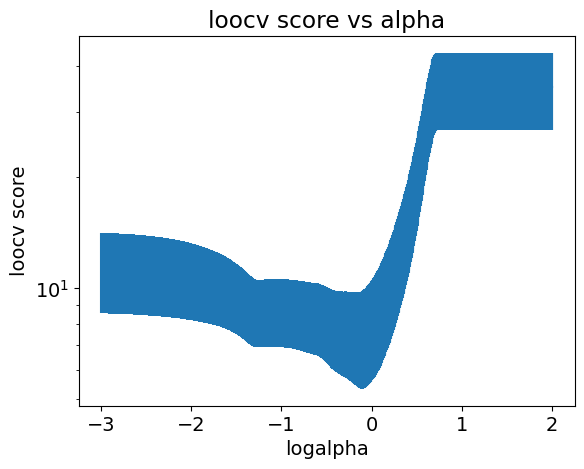

In [376]:
plt.yscale('log')
plt.errorbar(lasso_x_vals, lasso_y_vals, yerr=lasso_error_bars)
plt.xlabel('logalpha')
plt.ylabel('loocv score')
plt.title('loocv score vs alpha')

**(2h).** [2 pts] We can pick the value of alpha associated with the lowest mean LOOCV score. What is the best alpha and the corresponding mean LOOCV score?

In [377]:
print(f'Alpha= {alphas[lasso_y_vals.index(min(lasso_y_vals))]}')
print(f'LOOCV score= {min(lasso_y_vals)}')

Alpha= 0.7548799281653431
LOOCV score= 7.561956698123355


**(2i).**  [1 pt] Once we have selected the best alpha from LOOCV, we can select the model fitted with that alpha on all data (i.e. no held-out sample) as the best model. Display the coefficients in a pandas DataFrame.

In [378]:
lasso = linear_model.Lasso()

coefs = []
#set optimal alpha and fit
lasso.set_params(alpha=alphas[lasso_y_vals.index(min(lasso_y_vals))])
lasso.fit(X_train, y_train)
coefs.append(lasso.coef_)
#add back the intercept (mean y value for lasso)
coefs = np.array(coefs).T
coefs[0] = np.mean(y_train)
coefs = pd.DataFrame(coefs)
row_labels = {0: 'Intercept'}
for i in range(1, 11):
    row_labels[i] = feat_names[i-1]
coefs.rename(index= row_labels, inplace=True)
print(coefs)



                   0
Intercept  20.090625
cyl        -1.559903
disp       -0.000000
hp         -0.815383
drat        0.000000
wt         -2.634352
qsec        0.000000
vs          0.000000
am          0.000000
gear        0.000000
carb       -0.000000


**(2j).** [1 pt] The formula for LASSO effective degrees of freedom is:

\begin{equation*}
    \sum_{j=0}^p \mathbb{1}\left\{\hat{\beta}_j(\alpha)\neq 0\right\}
\end{equation*}

where $\hat{\beta}_j(\alpha)$ is the LASSO estimate of coefficient $\beta_j$ for a penalty parameter $\alpha$. This is the number of non-zero coefficients (including the intercept) in the LASSO regression. What is the number of degrees of freedom in the selected LASSO model? How does it compare with Ridge regression?

**A:** 4 degrees of freedom, much less than Ridge making it more sparse

**(2k).** [1 pt] How do you interpret the coefficient on cylinders? How does the interpretation compare with that for Ridge regression in (1l)?

Hint: You will need to apply the normalization (but not the centering) introduced in 1a to the coefficient before interpreting it.

**A:** The coefficient is still the predicted change in the target per unit change in the input, but now, it is per normalized unit (standard deviation) with its magnitude larger than that of ridge as it uses less features therefore allocating it more weight.

**(2l).** [1 pt] How do the mean LOOCV scores for the selected ridge and LASSO models compare? Why does this occur?

**A:** The mean LOOCV scores of Lasso outperform those of ridge likely because the majority of the features don't exhibit a strong enough relationship with the response and were mostly fitting noise

<b>Important Note:</b> If you look carefully into the implementation, you notice that we center/scale the data only once across the whole sample and don't standarize further when doing the LOOCV splits. Technically, we are introducing small leakage across training/hold-out sets (in this case the sub-sample of size $n-1$ and the remaining $i^{th}$ sample). To solve this problem, we should have re-centered/scaled for every sub-sample of size $n-1$ individually and used the scaling parameters to transform the remaining $i^{th}$ sample. However, since we are in the case of LOOCV, the leakage is so small (i.e. mean/std of $n$ numbers instead of $n-1$) that there is virtually no difference between the LOOCV curves. In the general case however, especially in cross-validation settings where the number of folds is small (5 for example) compared to the sample size, you should be very careful about leakage.